In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import gc

from sklearn.linear_model import SGDClassifier as SGDC
from sklearn.model_selection import train_test_split

In [2]:
MNIST=pd.read_csv(r"D://Datasets/MNIST/mnist_train.csv")

In [3]:
y=MNIST['label'].to_numpy()

y = y.reshape(y.shape[0], )
y=pd.Series(y)


M=MNIST.copy()
M.drop('label',axis=1,inplace=True)
X=M.copy()
del M
gc.collect()

171

In [4]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,shuffle=True,random_state=21)

In [5]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

<b>Training a Binary Classifier

In [6]:
sgd_clf = SGDC(random_state=21)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=21)

<b>Confusion Matrix</b>

A much better way to evaluate the performance of a classifier is to look at the confusion
matrix. The general idea is to count the number of times instances of class A are
classified as class B. For example, to know the number of times the classifier confused
images of 5s with 3s, you would look in the 5th row and 3rd column of the confusion
matrix.
To compute the confusion matrix, you first need to have a set of predictions, so they
can be compared to the actual targets

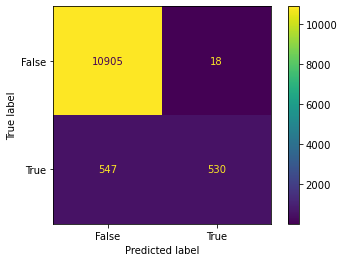

In [7]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(sgd_clf, X_test, y_test_5)

The confusion matrix gives you a lot of information, but sometimes you may prefer a
more concise metric. An interesting one to look at is the accuracy of the positive predictions;
this is called the precision of the classifier (Equation 3-1).

Equation 3-1. Precision
precision = TP/(TP + FP)

TP is the number of true positives, and FP is the number of false positives.

A trivial way to have perfect precision is to make one single positive prediction and
ensure it is correct (precision = 1/1 = 100%). This would not be very useful since the
classifier would ignore all but one positive instance. So precision is typically used
along with another metric named recall, also called sensitivity or true positive rate
(TPR): This is the ratio of positive instances that are correctly detected by the classifier
(Equation 3-2).

Equation 3-2. Recall
recall = TP/(TP + FN)

FN is of course the number of false negatives.

In [8]:
from sklearn.metrics import precision_score, recall_score

In [9]:
from sklearn.model_selection import cross_val_predict
y_test_pred = cross_val_predict(sgd_clf, X_test, y_test_5, cv=3)

print(precision_score(y_test_pred,y_test_5))
print(recall_score(y_test_pred,y_test_5))


0.8115134633240483
0.6702453987730062


It is often convenient to combine precision and recall into a single metric called the F1
score, in particular if you need a simple way to compare two classifiers. The F1 score is
the harmonic mean of precision and recall (Equation 3-3). Whereas the regular mean
treats all values equally, the harmonic mean gives much more weight to low values.
As a result, the classifier will only get a high F1 score if both recall and precision are
high.

In [10]:
from sklearn.metrics import f1_score
f1_score(y_test_5, y_test_pred)

0.7341453170936583

The F1 score favors classifiers that have similar precision and recall. This is not always
what you want: in some contexts you mostly care about precision, and in other contexts
you really care about recall. 

For example, if you trained a classifier to detect videos
that are safe for kids, you would probably prefer a classifier that rejects many
good videos (low recall) but keeps only safe ones (high precision), rather than a classifier
that has a much higher recall but lets a few really bad videos show up in your
product (in such cases, you may even want to add a human pipeline to check the classifier’s
video selection). 

On the other hand, suppose you train a classifier to detect
shoplifters on surveillance images: it is probably fine if your classifier has only 30%
precision as long as it has 99% recall (sure, the security guards will get a few false
alerts, but almost all shoplifters will get caught).

Unfortunately, you can’t have it both ways: increasing precision reduces recall, and
vice versa. This is called the precision/recall tradeoff.

In [41]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_test, y_test_5, cv=3,method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_test_5, y_scores)

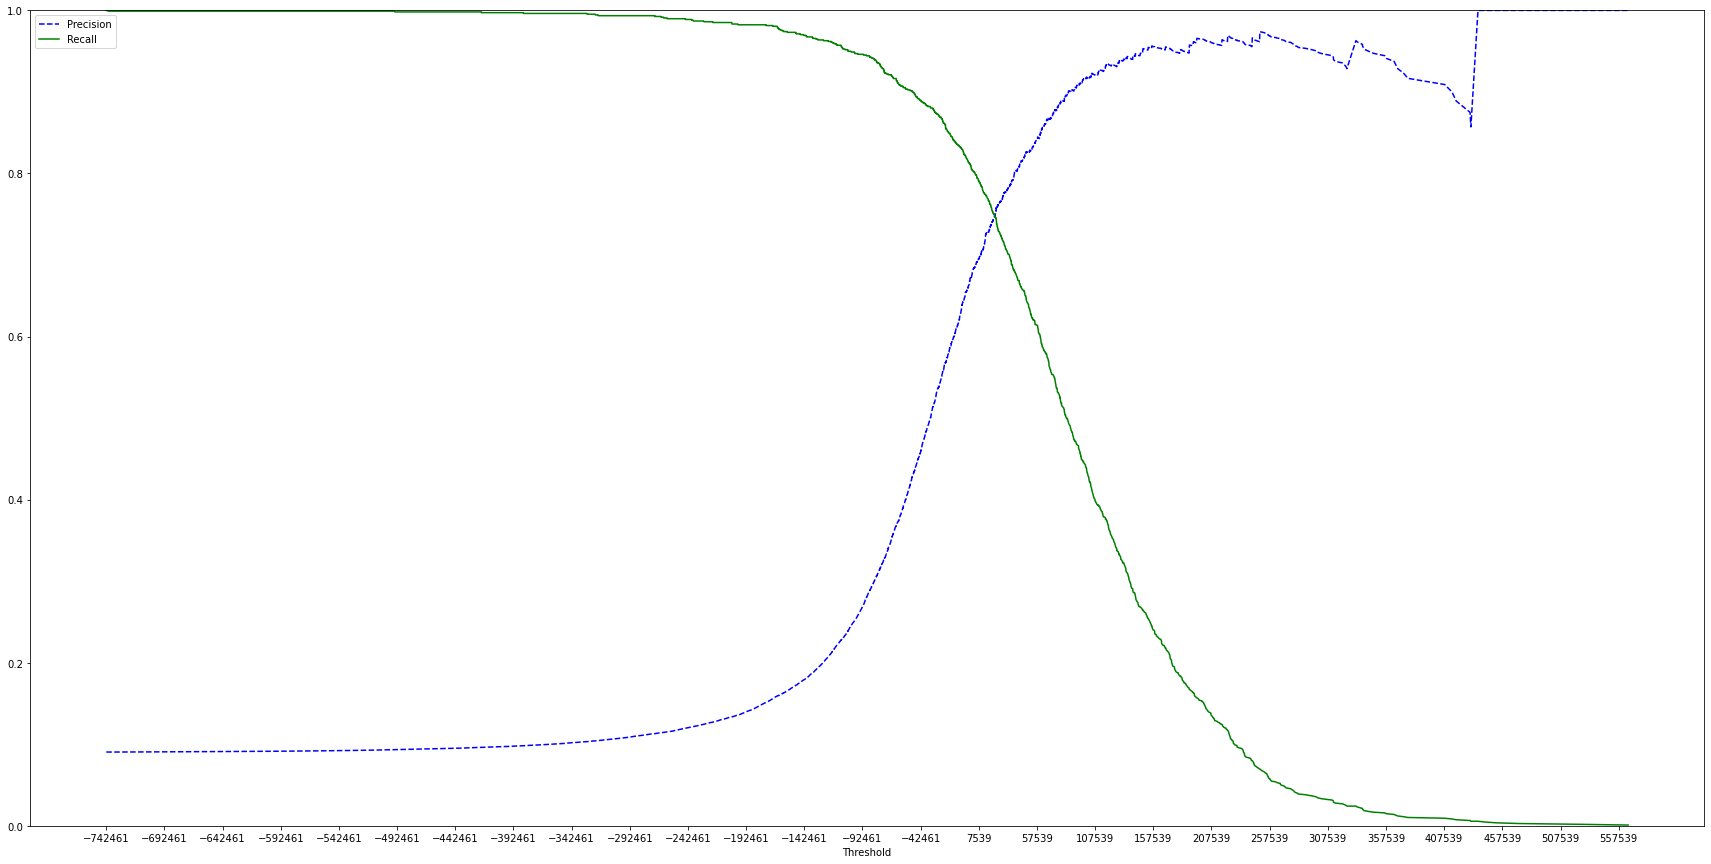

In [47]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    plt.xticks(range(int(min(thresholds)),int(max(thresholds)+1),50000))
    
plt.figure(figsize=(30,15))    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

You may wonder why the precision curve is bumpier than the recall
curve.

The reason is that precision may sometimes go
down when you raise the threshold (although in general it will go
up).

On the other hand, recall can only go down when the threshold
is increased, which explains why its curve looks smooth.

Now you can simply select the threshold value that gives you the best precision/recall
tradeoff for your task.

Another way to select a good precision/recall tradeoff is to plot
precision directly against recall

<AxesSubplot:>

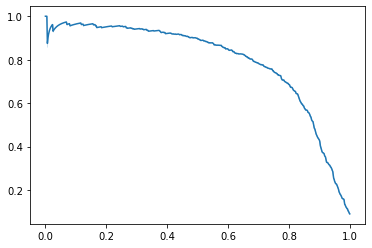

In [48]:
sns.lineplot(x=recalls,y=precisions)

So let’s suppose you decide to aim for 90% precision. You look up the first plot
(zooming in a bit) and find that you need to use a threshold of about 100000. To make
predictions (on the training set for now), instead of calling the classifier’s predict()
method, you can just run this code:

In [54]:
y_test_pred_90 = (y_scores > 100000)

#Let’s check these predictions’ precision and recall:

print(precision_score(y_test_5, y_test_pred_90))
print(recall_score(y_test_5, y_test_pred_90))

0.9182879377431906
0.4382544103992572


Great, you have a 90% precision classifier (or close enough)! As you can see, it is
fairly easy to create a classifier with virtually any precision you want: just set a high
enough threshold, and you’re done. Hmm, not so fast. A high-precision classifier is
not very useful if its recall is too low!

<b>The ROC Curve</b>

The receiver operating characteristic (ROC) curve is another common tool used with
binary classifiers. It is very similar to the precision/recall curve, but instead of plotting
precision versus recall, the ROC curve plots the true positive rate (another name
for recall) against the false positive rate. 

The FPR is the ratio of negative instances that
are incorrectly classified as positive. 

It is equal to one minus the true negative rate,
which is the ratio of negative instances that are correctly classified as negative. The
TNR is also called specificity. 

Hence the ROC curve plots sensitivity (recall) versus
1 – specificity.

In [55]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test_5, y_scores)

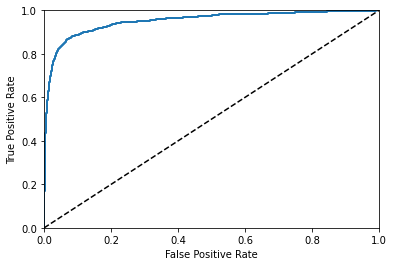

In [57]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc_curve(fpr, tpr)
plt.show()

Once again there is a tradeoff: the higher the recall (TPR), the more false positives
(FPR) the classifier produces. The dotted line represents the ROC curve of a purely
random classifier; a good classifier stays as far away from that line as possible (toward
the top-left corner).
One way to compare classifiers is to measure the area under the curve (AUC). A perfect
classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5. Scikit-Learn provides a function to compute the ROC
AUC:

In [58]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test_5, y_scores)

0.9515776468877143

Let’s train a RandomForestClassifier and compare its ROC curve and ROC AUC
score to the SGDClassifier. First, you need to get scores for each instance in the
training set. But due to the way it works (see Chapter 7), the RandomForestClassi
fier class does not have a decision_function() method. Instead it has a pre
dict_proba() method. Scikit-Learn classifiers generally have one or the other. The
predict_proba() method returns an array containing a row per instance and a column
per class, each containing the probability that the given instance belongs to the
given class

In [59]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=21)
y_probas_forest = cross_val_predict(forest_clf, X_test, y_test_5, cv=3,
method="predict_proba")

In [61]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_test_5,y_scores_forest)

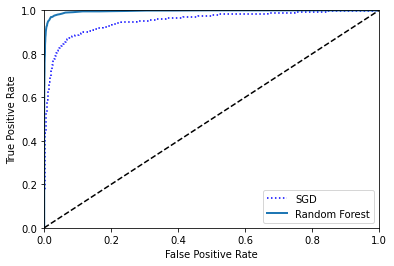

In [63]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [64]:
roc_auc_score(y_test_5, y_scores_forest)

0.9961975322998304

In [69]:
y_test_pred = (y_scores_forest > 0.5)

precision_score(y_test_5, y_test_pred)

0.9854721549636803

In [70]:
recall_score(y_test_5, y_test_pred)

0.755803156917363